In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import matplotlib.patches as mpatches
import time
from datetime import timedelta
import seaborn as sns

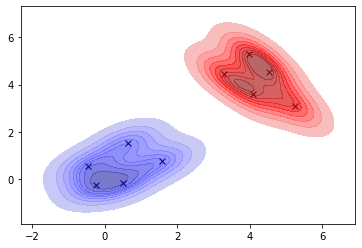

In [2]:
#SAMPLE ARRAYS OF RANDOMLY GENERATED DATA (INPUT ROW-WISE - D x N ARRAY) (D = DIMENSIONS/ROWS, N = OBSERVATIONS/COLUMNS)

np.random.seed(42)

#SAMPLE A
X1, X2 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 5).T
sns.kdeplot(x = X1, y = X2, color='b', shade = True, alpha = 0.75)
plt.plot(X1, X2, 'x', color = 'darkblue')

#SAMPLE B
Y1, Y2 = np.random.multivariate_normal([5, 5], [[1, 0], [0, 1]], 5).T
sns.kdeplot(x = Y1, y = Y2, color='r', shade = True, alpha = 0.75)
plt.plot(Y1, Y2, 'x', color = 'darkred')

#DISTRIBUTIONS
X = np.vstack((X1, X2))
Y = np.vstack((Y1, Y2))
Z = np.hstack((X, Y))

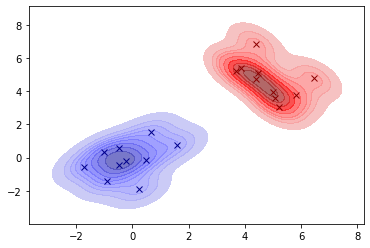

In [3]:
#MORE STUFF
np.random.seed(42)

#SAMPLE A
X1, X2 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 10).T
sns.kdeplot(x = X1, y = X2, color='b', shade = True, alpha = 0.75)
plt.plot(X1, X2, 'x', color = 'darkblue')

#SAMPLE B
Y1, Y2 = np.random.multivariate_normal([5, 5], [[1, 0], [0, 1]], 10).T
sns.kdeplot(x = Y1, y = Y2, color='r', shade = True, alpha = 0.75)
plt.plot(Y1, Y2, 'x', color = 'darkred')

#DISTRIBUTIONS
X = np.vstack((X1, X2))
Y = np.vstack((Y1, Y2))
Z = np.hstack((X, Y))

In [4]:
#OPTIMAL BANDWIDTH SELECTION USING SILVERMAN'S RULE OF THUMB

#MULTIVARIATE VERSION (PROPORTIONAL TO COVARIANCE) (INPUT DxN MATRIX) (RETURNS DIAGONAL DxD MATRIX)
def bandwidth(X, n):
    d = X.shape[0]
    const = (4/(n*(d+2)))**(2/(d+4))
    cov = np.cov(X, bias = True)
    diag_elems = cov.diagonal()
    diag = np.diag(diag_elems)
    return const*diag

n = X.shape[1]
m = Y.shape[1]
k = Z.shape[1]

Hx = bandwidth(X, n)
Hy = bandwidth(Y, m)
Hy_alt = bandwidth(Y, k)
Hz = bandwidth(Z, k)

In [5]:
#MULTIVARIATE GAUSSIAN (INPUT 1xD ARRAY) (RETURNS 1x1)
def multi_gaussian(X, Xi, H):
    d = X.shape[0]
    c = np.sqrt(np.linalg.det(H)*(2*np.pi)**d)
    value = np.exp(((X-Xi) @ np.linalg.inv(H) @ (X-Xi).T)/(-2)) / c
    return value

def kernel_func(X, Y, H):
    n = X.shape[0]
    gaussian = 0
    for i in range(n):
        gaussian += multi_gaussian(X[i], Y[i], H)
    return gaussian/n
    
#TESTING MULTI-KERNEL FUNCTION
print("KERNEL: ")
k = kernel_func(X.T, X.T, Hx)
print(k)

KERNEL: 
0.39250400359919885


In [6]:
#COST FUNCTION USING SQUARED EUCLIDEAN NORM

#SIMPLE NUMPY FORM FOR MULTIVARIATE AND 1D
def C(X, Tx):
    return (np.linalg.norm(Tx - X)**2)/(2 * X.shape[0])
    
#TESTING COST FUNCTION
C_check = C(X.T, Y.T)
print("C:", C_check)

C: 26.105756587244674


In [7]:
#F1 FUNCTION (INPUT NxD MATRIX) (RETURNS Nx1 ARRAY)
def F1(Y, Tx, Hx, Hy):
    n = Tx.shape[0]
    m = Y.shape[0]
    FA = 0
    FB = 0
    for i in range(n):
        for j in range(n):
            FA += multi_gaussian(Tx[i], Tx[j], Hx)
        for k in range(m):
            FB += multi_gaussian(Tx[i], Y[k], Hy)
    return ((FA/n)-(FB/m)) / n

#F2 FUNCTION (INPUT NxD MATRIX) (RETURNS Nx1 ARRAY)
def F2(Y, Tx, Hx, Hy):
    n = Tx.shape[0]
    m = Y.shape[0]
    FA = 0
    FB = 0
    for i in range(m):
        for j in range(n):
            FA += multi_gaussian(Y[i], Tx[j], Hx)
        for k in range(m):
            FB += multi_gaussian(Y[i], Y[k], Hy)
    return ((FA/n)-(FB/m)) / m

#TESTING F1 MULTIVARIATE
F1_check = F1(Y.T, X.T, Hx, Hy)
print("F1 ND:")
print(F1_check)

#TESTING F2 MULTIVARIATE
F2_check = F2(Y.T, X.T, Hx, Hy)
print("F2 ND:")
print(F2_check)

F1 ND:
0.08274453752795753
F2 ND:
-0.10083229100452855


In [8]:
#L FUNCTION TO MINIMIZE OVER
def L(X, Y, Tx, lam, Hx, Hy):
    L1 = C(X, Tx)
    L2 = lam * (F1(Y, Tx, Hx, Hy) - F2(Y, Tx, Hx, Hy))
    return L1 + L2

#TESTING MULTIVARIATE L FUNCTION
L_check = L(X.T, Y.T, X.T, 0.2, Hz, Hz)
print("ND CHECK:")
print("L1:", C(X.T, X.T))
print("L2:", F1(Y.T, X.T, Hz, Hz) - F2(Y.T, X.T, Hz, Hz))
print("L:", L_check)

ND CHECK:
L1: 0.0
L2: 0.07414175225920219
L: 0.014828350451840439


In [9]:
#COST GRADIENT DEFINITION W/ RESPECT TO EACH TX_i (WILL STACK LATER FOR RUNTIME SAKE)
def C_grad_i(X_i, Tx_i):
    return (Tx_i - X_i)/(np.size(X_i))

#TESTING C_GRAD FUNCTION
C_grad_check = 0
n = X.shape[1]
print("C GRAD:")
for i in range(n):
    C_grad_check = C_grad_i(X.T[i], X.T[i])
    #print(C_grad_check)

C GRAD:


In [10]:
#F1 GRADIENT DEFINITION W/ RESPECT TO EACH TX_i (WILL STACK LATER FOR RUNTIME SAKE)
def F1_grad_i(Tx, Y, Txi, Hx, Hy):
    n = Tx.shape[0]
    d = Tx.shape[1]
    m = Y.shape[0]
    gradFA = np.zeros(d)
    gradFB = np.zeros(d)
    for j in range(n): #SUM OF ALL GAUSSIAN DERIVATIVES WRT TX_j
        gradFA += multi_gaussian(Txi, Tx[j], Hx) * (np.linalg.inv(Hx) @ (Tx[j] - Txi))
    for k in range(m): #SUM OF ALL GAUSSIAN DERIVATVIES WRT Y_k
        gradFB += multi_gaussian(Txi, Y[k], Hy) * (np.linalg.inv(Hy) @ (Y[k] - Txi))
    return ((gradFA/n)-(gradFB/m)) / n
    
#F2 GRADIENT DEFINITION W/ RESPECT TO Y_i (WILL STACK LATER FOR RUNTIME SAKE)
def F2_grad_i(Tx, Txj, Y, Hx):
    n = Tx.shape[0]
    d = Tx.shape[1]
    m = Y.shape[0]
    gradFA = np.zeros(d)
    for i in range(m): #SUM OF ALL GAUSSIANS DERIVATIVES WRT TX_j 
        gradFA += multi_gaussian(Y[i], Txj, Hx) * (np.linalg.inv(Hx) @ (Y[i] - Txj))
    return (gradFA/(n*m))

#TESTING MULTIVARIATE F1 GRADIENT FUNCTION
n = X.shape[1]
d = X.shape[0]
F1_grad = np.zeros(d)
#print("F1 GRAD:")
for i in range(n):
    F1_grad = F1_grad_i(X.T, Y.T, X.T[i], Hx, Hy)

#TESTING MULTIVARIATE F2 GRADIENT FUNCTION
n = X.shape[1]
d = X.shape[0]
F2_grad = np.zeros(d)
#print("F2 GRAD:")
for j in range(n):
    F2_grad = F2_grad_i(X.T, X.T[j], Y.T, Hx)

In [11]:
#l GRADIENT DEFINITION
def L_grad(X, Y, Tx, lam, Hx, Hy):
    n = X.shape[0]
    d = X.shape[1]
    gradL = np.zeros(d)
    for i in range(n):
        val_i = C_grad_i(X[i], Tx[i]) + lam*(F1_grad_i(Tx, Y, Tx[i], Hx, Hy) - F2_grad_i(Tx, Tx[i], Y, Hy))
        gradL = np.vstack((gradL, val_i))
    return gradL[1:]

#TESTING MULTIVARIATE VERSION
Lgrad = L_grad(X.T, Y.T, X.T, 0.2, Hx, Hy)
#print("L GRAD:")
#print(Lgrad)

In [12]:
#ADAPT LAMBDA PENALTY PARAMETER
def adapt_penalty(X, Y, Tx, Hx, Hy, alpha):
    n = X.shape[0]
    m = Y.shape[0]
    
    #MAKING GRADIENTS INTO MATRIX
    gradL1 = np.zeros(2)
    gradL2 = np.zeros(2)
    for i in range(n):
        gradL1i = C_grad_i(X[i], Tx[i])
        gradL2i = F1_grad_i(Tx, Y, Tx[i], Hx, Hy) - F2_grad_i(Tx, Tx[i], Y, Hy)
        gradL1 = np.vstack((gradL1, gradL1i))
        gradL2 = np.vstack((gradL2, gradL2i))
    gradL1 = gradL1[1:]
    gradL2 = gradL2[1:]
    
    #FROBENIUS INNER PRODUCT BETWEEN MATRICES = TRACE OF A.T * B
    inner_prod = np.trace(gradL1.T @ gradL2)
    
    #SQUARED FROBENIUS NORM OF F1-F2
    L2_norm = np.linalg.norm(gradL2)**2
    
    #CALCULATE LAMBDA VALUES
    lam = (alpha - inner_prod) / L2_norm    
    return lam

#TESTING ADAPTIVE PENALTY MULTIVARIATE
lam = adapt_penalty(X.T, Y.T, X.T, Hx, Hy, 0.2)
print("LAMBDA ND:", lam)

LAMBDA ND: 597.2310871668192


In [13]:
#ADAPT LEARNING RATE
def adapt_learning(X, Y, Tx_curr, lam, eta, Hx, Hy):
    n = X.shape[0]
    m = Y.shape[0]
    
    #INITIALIZE NEW MAP Tx_n+1
    eta *= 2
    Tx_new = X - (eta * L_grad(X, Y, Tx_curr, lam, Hx, Hy))

    #INITIALIZE Ln AND Ln+1 BASED ON Tx_n+1
    L_curr = L(X, Y, Tx_curr, lam, Hx, Hy)
    L_next = L(X, Y, Tx_new, lam, Hx, Hy)
        
    while L_next > L_curr:
        #print("next: ", L_next)
        #print("curr: ", L_curr)
        #print(eta)
        eta /= 2
        Tx_new = Tx_curr - eta * L_grad(X, Y, Tx_curr, lam, Hx, Hy)
        L_curr = L(X, Y, Tx_curr, lam, Hx, Hy)
        L_next = L(X, Y, Tx_new, lam, Hx, Hy)
        
    return (eta, Tx_new)

eta = adapt_learning(X.T, Y.T, X.T, 125, 0.01, Hx, Hy)
#print("ETA:", eta[0])
#print("Tx NEW:", eta[1])

In [14]:
#CONSTANT SELECTION FOR INITIAL BANDWIDTH
def init_bandwidth(Y, Tx_new, Hz):
    const = 1
    n = X.shape[0]
    gauss_curr = 0
    gauss_next = 0
    while gauss_next <= gauss_curr:
        for i in range(n):
            gauss_curr += multi_gaussian(Tx_new[i], Y[i], Hz)
            gauss_next += multi_gaussian(Tx_new[i], Y[i], const*Hz)
        const += 1
    return (const)

#ADAPT BANDWIDTH (DECREASES TO GET CLOSER TO Hy AS ITERATIONS PROGRESS)
def adapt_bandwidth(Hy, Hz, i, it):
    Hz_new = (8 * Hz * (it - i) / it) + (Hy * i / it)
    return Hz_new

#TESTING BANDWIDTH FUNCTION
for i in range(10):
    #print("ITER", i)
    bw = adapt_bandwidth(Hy, Hz, i, 10)
    #print(bw)

In [19]:
#GRADIENT DESCENT
def gradient_descent(X, Y, eta, it, alpha):
    print("GRAD DESCENT")
    Z = np.vstack((X, Y))
    n = X.shape[0]
    m = Y.shape[0]
    k = Z.shape[0]

    #INITIALIZING BANDWIDTHS AND LAMBDA
    Hx = bandwidth(X.T, n)
    Hy = bandwidth(Y.T, k)
    Hz_init = bandwidth(Z.T, k)
    
    #INITIALIZING HISTORIES
    T_hist = [X]
    L1_hist = []
    L2_hist = []
    L_hist = []
    eta_hist = []
    lam_hist = []
    
    #STARTING POINT FOR MAP T(X)
    Tx_curr = X
    Tx_next = X
    
    #START ITERATIONS
    for i in range(it):
        if (i % 10 == 0):
            print("ITER", i)

        #LINEARLY INCREASING BANDWIDTH AND LAMBDA
        Hz = adapt_bandwidth(Hy, Hz_init, i, it)
        lam = adapt_penalty(X, Y, Tx_next, Hx, Hy, alpha)
        
        #GETTING NEW ETA AND TX VALUES
        eta_Tnew = adapt_learning(Tx_curr, Y, Tx_next, lam, eta, Hz, Hz)
        eta = eta_Tnew[0]
        Tx_curr = Tx_next
        Tx_next = eta_Tnew[1]

        #APPENDING TO HISTORY
        eta_hist.append(eta)
        lam_hist.append(lam)
        T_hist.append(Tx_next)
        L1_hist.append(C(X, Tx_next))
        L2_hist.append(F1(Y, Tx_next, Hz, Hz) - F2(Y, Tx_next, Hz, Hz))
        L_hist.append(C(X, Tx_next) + lam*(F1(Y, Tx_next, Hz, Hz) - F2(Y, Tx_next, Hz, Hz)))
        
    return (T_hist, L1_hist, L2_hist, L_hist, eta_hist, lam_hist)

GRAD DESCENT
ITER 0
ITER 10
ITER 20
ITER 30
ITER 40
RUNTIME: 0.0 hrs 0.0 min 15.0 sec


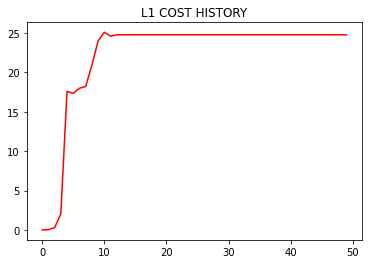

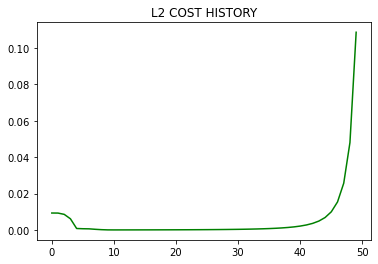

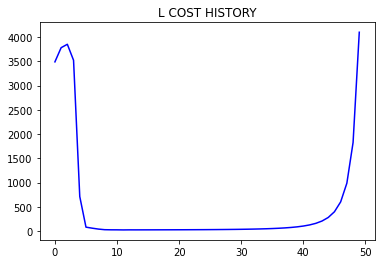

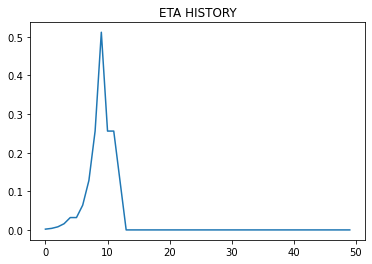

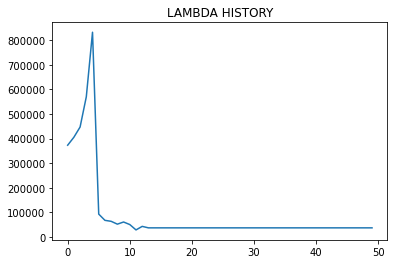

In [20]:
#RUNNING GRADIENT DESCENT
start_time = time.time()
grad = gradient_descent(X.T, Y.T, 0.001, 50, 125)

runtime = time.time() - start_time
hours = runtime // 3600
runtime = runtime - hours*3600
minutes = runtime // 60
seconds = runtime - minutes*60
print("RUNTIME:", hours, "hrs", minutes, "min", seconds//1, "sec")

#PLOTTING COSTS
L1 = grad[1]
L2 = grad[2]
L3 = grad[3]
eta_hist = grad[4]
lam_hist = grad[5]
t=[i for i in range(50)]

#PLOT L1 COST (SHOULD INCREASE)
plt.title("L1 COST HISTORY")
plt.plot(t, L1, "r")
plt.show()

#PLOT L2 COST (SHOULD DECREASE)
plt.title("L2 COST HISTORY")
plt.plot(t, L2, "g")
plt.show()

#PLOT L HISTORY (SHOULD HAVE NET DECREASE)
plt.title("L COST HISTORY")
plt.plot(t, L3, "b")
plt.show()

#PLOT ETA HISTORY
plt.title("ETA HISTORY")
plt.plot(t, eta_hist)
plt.show()

#PLOT LAMBDA HISTORY
plt.title("LAMBDA HISTORY")
plt.plot(t, lam_hist)
plt.show()

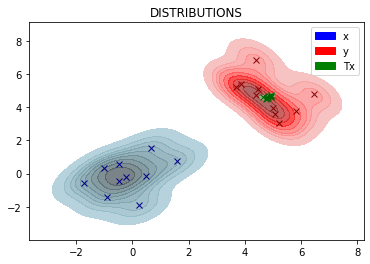

In [21]:
#PLOTTING Tx AND CONTOUR PLOT
Tx = grad[0][-1]
Tx1 = Tx.T[0]
Tx2 = Tx.T[1]

plt.plot(X1, X2, 'x', color = 'darkblue')
sns.kdeplot(x = X1, y = X2, color='lightblue', shade = True, alpha = 0.75)

plt.plot(Y1, Y2, 'x', color = 'darkred')
sns.kdeplot(x = Y1, y = Y2, color='r', shade = True, alpha = 0.75)

plt.plot(Tx1, Tx2, 'x', color = 'darkgreen')
sns.kdeplot(x = Tx1, y = Tx2, color='lightgreen', shade = True, alpha = 0.75)

plt.title("DISTRIBUTIONS")

blue = mpatches.Patch(color = 'blue', label = 'x')
red = mpatches.Patch(color = 'red', label = 'y')
green = mpatches.Patch(color = 'green', label = 'Tx')
plt.legend(handles = [blue, red, green])
plt.show()

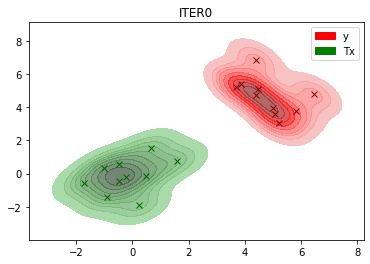

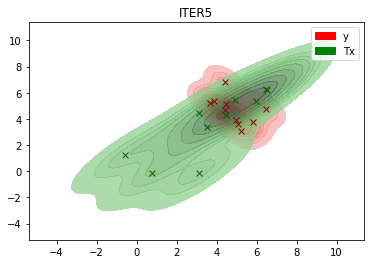

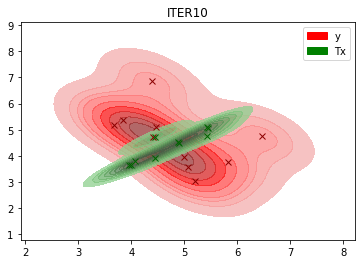

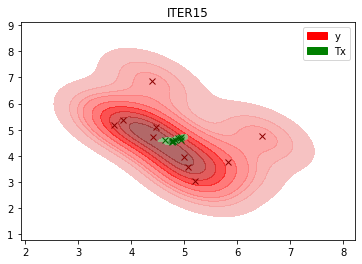

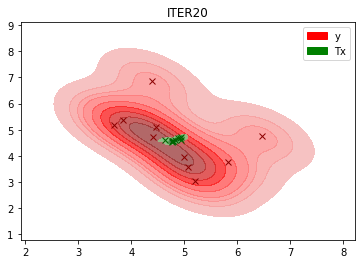

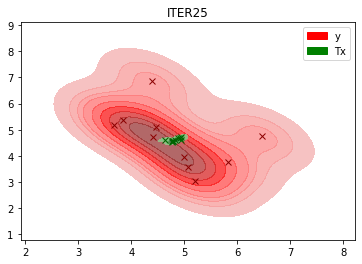

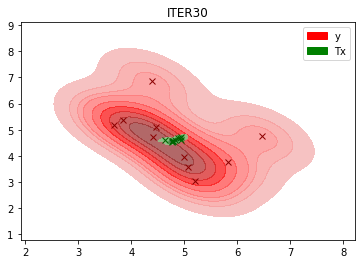

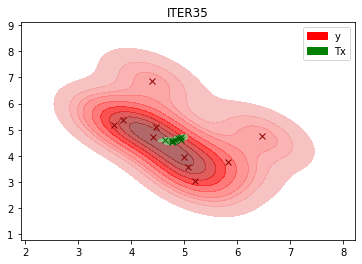

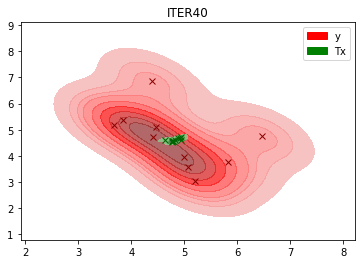

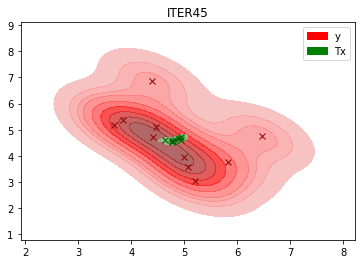

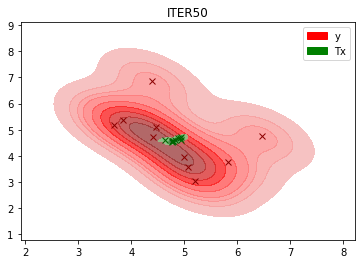

In [22]:
for i in range(51):
    if (i % 5 == 0):
        Tx = grad[0][i]
        Tx1 = Tx.T[0]
        Tx2 = Tx.T[1]

        plt.plot(Y1, Y2, 'x', color = 'darkred')
        sns.kdeplot(x = Y1, y = Y2, color='r', shade = True, alpha = 0.75)

        plt.plot(Tx1, Tx2, 'x', color = 'darkgreen')
        sns.kdeplot(x = Tx1, y = Tx2, color='lightgreen', shade = True, alpha = 0.75)

        plt.title("ITER" + str(i))

        red = mpatches.Patch(color = 'red', label = 'y')
        green = mpatches.Patch(color = 'green', label = 'Tx')
        plt.legend(handles = [red, green])
        plt.show()